In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import re
import itertool
import os
import os.path
from Bio import motifs
from Bio import SeqIO
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
%matplotlib inline

In [2]:
# get ENCODE TF binding sites
tfbs = pd.read_table('c:/ravip/encode/wgEncodeRegTfbsClusteredV3.bed.gz',
                     header=None,names=['seqname','start','end','gene','V1','V2','V3','V4'],
                     dtype={'start':np.int, 'end':np.int})

In [3]:
dna = pd.read_table('d:/sequence/pancan/tcga505/mutations.tsv.gz', dtype={'chr': np.character})
dna_rnd = pd.read_table('d:/sequence/pancan/tcga505/randomised_TCGA505_toshare.txt.gz',
                        header=None,names=['barcode', 'cancer', 'chr', 'pos', 'ref_allele', 'var_allele'],
                        dtype={'chr': np.character}, skiprows=1)
dna['rnd'] = False
dna_rnd['rnd'] = True
dna_all = dna.append(dna_rnd)
dna_all['chr'] = ['chr' + x for x in dna_all['chr']]

In [4]:
# get a set of TF binding matrices
h = open('pfm_vertebrates.txt')
jaspar = {m.name.strip().split(':')[0].upper(): m.counts.normalize().log_odds() for m in motifs.parse(h, 'jaspar')}
h.close()

In [5]:
# reduce tfbs to those for which we have matrices
print len(set(tfbs['gene'])), len(set(jaspar.keys())), len(set(tfbs['gene']).intersection(set(jaspar.keys())))
common = set(tfbs['gene']).intersection(set(jaspar.keys()))
tfbs2 = tfbs[tfbs['gene'].apply(lambda g: g in common)]

161 196 80


In [6]:
# get reference genome
hg19 = {contig.name: Seq(str(contig.seq), IUPAC.unambiguous_dna)
        for contig in SeqIO.parse('d:/sequence/genomes/hg19.fa', 'fasta')}

In [7]:
# left join by genomic regions
# limitations:
# genomic range columns (rcols1, rcols2) must be distinct
# only works if region sets are non-overlapping
# drops duplicates
def merge_regions(df1, cols1, df2, cols2):
    result = None
    [seqname1, start1, end1] = cols1[:3]
    [seqname2, start2, end2] = cols2[:3]
    cols1 = list(pd.Series(cols1).drop_duplicates())
    cols2 = list(pd.Series(cols2).drop_duplicates())
    for contig in set(df1[seqname1]).intersection(set(df2[seqname2])):
        c1 = df1[df1[seqname1]==contig].sort(end1).reset_index(drop=True)
        c2 = df2[df2[seqname2]==contig].sort(start2).drop_duplicates(start2).reset_index(drop=True)
        imerge = pd.cut(c1[end1], c2[start2], labels=False)
        keep = imerge >= 0
        cmerge = pd.concat([c1[cols1][keep], c2[cols2].iloc[imerge[keep]].reset_index(drop=True)], axis=1).reset_index(drop=True)
        cmerge = cmerge[cmerge[start1] <= cmerge[end2]]
        result = cmerge if result is None else pd.concat([result, cmerge])
    return result

In [8]:
# find TF binding regions matching mutations
mut_tf = merge_regions(dna_all, ['chr', 'pos', 'pos', 'ref_allele', 'var_allele', 'cancer', 'barcode', 'rnd'],
                       tfbs2, ['seqname', 'start', 'end', 'gene'])

In [9]:
# score TF binding to mutation using TF matrix
def score_mut(m):
    mx = jaspar[m['gene']]
    n = len(mx[mx.keys()[0]])
    p = int(m['pos'])
    refseq = hg19[m['chr']][p-n-1:p+n]
    refscore = reduce(max, (score for pos, score in mx.search(refseq, threshold=0.5)), 0)
    mutseq = refseq[:n] + m['var_allele'] + refseq[n+1:]
    mutscore = reduce(max, (score for pos, score in mx.search(mutseq, threshold=0.5)), 0)
    return mutscore - refscore

In [15]:
from ipyparallel import Client
c = Client()
dview = c[:]

In [16]:
# push small global dataset, processing function
dview.push(dict(jaspar=jaspar, score_mut=score_mut))
# push hg19 doesn't work (reboots machine!), so read it in from each node
%px from Bio import motifs
%px from Bio import SeqIO
%px from Bio.Alphabet import IUPAC
%px from Bio.Seq import Seq
%px hg19 = {contig.name: Seq(str(contig.seq), IUPAC.unambiguous_dna) for contig in SeqIO.parse('d:/sequence/genomes/hg19.fa', 'fasta')}
# partition input DataFrame across nodes
dview.scatter('mut_tf', mut_tf)

<AsyncResult: scatter>

In [21]:
# run in parallel across all nodes ~4h on 20 cores
%px mut_tf_delta = mut_tf.apply(score_mut, axis=1)
mut_tf['delta'] = [x for x in itertools.chain(*dview.gather('mut_tf_delta').get())]

In [40]:
print mut_tf.describe()
mut_tf[:10]

                pos         start           end            delta
count  1.414138e+07  1.414138e+07  1.414138e+07  14141378.000000
mean   7.460602e+07  7.469213e+07  7.469242e+07        -0.047831
std    4.859062e+07  4.857125e+07  4.857125e+07         1.280569
min    8.610000e+02  8.930000e+02  1.129000e+03       -27.142241
25%    3.486641e+07  3.498561e+07  3.498602e+07         0.000000
50%    6.731618e+07  6.745097e+07  6.745121e+07         0.000000
75%    1.062043e+08  1.063074e+08  1.063077e+08         0.000000
max    2.492398e+08  2.492397e+08  2.492401e+08        20.778378


,chr,pos,ref_allele,var_allele,barcode,rnd,seqname,start,end,gene,delta
13,chrY,2654285,G,A,TCGA-DA-A1HY-06A,False,chrY,2655169,2655545,YY1,0
19,chrY,2657294,G,T,TCGA-05-4395-01A,True,chrY,2657879,2658063,CTCF,0
34,chrY,2663640,A,C,TCGA-CA-6718-01A,True,chrY,2664424,2664734,CTCF,0
35,chrY,2665082,C,A,TCGA-AD-6964-01A,False,chrY,2665095,2665321,CEBPB,0
45,chrY,2667747,A,G,TCGA-ER-A19J-06A,True,chrY,2668277,2668694,CTCF,0
46,chrY,2668325,A,C,TCGA-CA-6717-01A,False,chrY,2668277,2668694,CTCF,0
47,chrY,2668388,T,C,TCGA-37-4135-01A,True,chrY,2668277,2668694,CTCF,0
48,chrY,2668392,C,-TTA,TCGA-AA-A01R-01A,True,chrY,2668277,2668694,CTCF,0
49,chrY,2668457,G,T,TCGA-52-7812-01A,True,chrY,2668277,2668694,CTCF,0
106,chrY,2686532,G,C,TCGA-05-4395-01A,True,chrY,2686696,2686956,FOSL2,0


KeyError: 0L

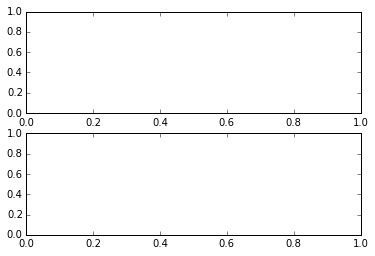

In [125]:
# compare rnd vs donor
fig, axes = plt.subplots(nrows=2)
ax0, ax1 = axes.flat
hdata = mut_tf[mut_tf['delta']!=0].reset_index(drop=True)
ax0.hist(hdata['delta'][hdata['rnd']==True].sample(n=100000), bins=100, normed=True)
ax1.hist(hdata['delta'][hdata['rnd']==False].sample(n=100000).reset_index(drop=True), bins=100, normed=True)
plt.tight_layout()
plt.show()

In [42]:
# get DHS-gene (enhancer-promoter) table from Sheffield et al
dhsgene = pd.read_table('c:/ravip/encode/allGeneCorrelations100000.p05.txt.gz')

# join mutation TF region (enhancer) with promoter & target gene
mut_tf_prom_dhs = merge_regions(mut_tf, ['seqname', 'start', 'end', 'gene', 'cancer', 'barcode', 'delta', 'rnd'],
                           dhsgene, ['dhs_chr', 'dhs_start', 'dhs_end', 'gene_name', 'cor'])

In [144]:
# get enhancer-gene assoiation from He et al
def read_he(f):
    df = pd.read_csv(os.path.join('data/he', f), header=1)
    df['CellLine'] = f[:-4]
    return df
hegene = pd.concat((read_he(f) for f in os.listdir('data/he') if f.endswith('.csv'))).rename(columns={'ID': 'gene_name'})
mut_tf_prom_he = merge_regions(mut_tf, ['seqname', 'start', 'end', 'gene', 'cancer', 'barcode', 'delta', 'rnd'],
                           hegene, ['Chr', 'Start', 'End', 'gene_name'])
mut_tf_prom_he[:10]

In [163]:
# get enhancer-gene association from Ernst et al
def read_ernst(f):
    df = pd.read_csv(os.path.join('data/ernst', f), names=['enhchr','enhstart','enhend','gene_name'], sep='\t')
    df['CellLine'] = f.split('_')[1]
    return df
ernstgene = pd.concat((read_ernst(f) for f in os.listdir('data/ernst') if f.startswith('links_') & f.endswith('.txt')))
mut_tf_prom_ernst = merge_regions(mut_tf, ['seqname', 'start', 'end', 'gene', 'cancer', 'barcode', 'delta', 'rnd'],
                           ernstgene, ['enhchr','enhstart','enhend', 'gene_name'])
mut_tf_prom_ernst[:10]

,seqname,start,end,gene,barcode,delta,rnd,enhchr,enhstart,enhend,gene_name
489,chrX,219573,219863,CEBPB,TCGA-EY-A1GW-01A,0.000000,True,chrX,279400,279600,NM_013239
490,chrX,219573,219863,CEBPB,TCGA-AP-A051-01A,0.000000,True,chrX,279400,279600,NM_013239
491,chrX,220037,220281,EGR1,TCGA-D8-A27H-01A,0.000000,False,chrX,279400,279600,NM_013239
492,chrX,220037,220281,EGR1,TCGA-FS-A1ZK-06A,-1.428373,False,chrX,279400,279600,NM_013239
493,chrX,220037,220281,EGR1,TCGA-AP-A0LD-01A,0.000000,True,chrX,279400,279600,NM_013239
494,chrX,220037,220281,EGR1,TCGA-KN-8418-01A,0.000000,True,chrX,279400,279600,NM_013239
495,chrX,220037,220281,EGR1,TCGA-DK-A1AG-01A,0.000000,True,chrX,279400,279600,NM_013239
496,chrX,220037,220281,EGR1,TCGA-56-1622-01A,0.000000,False,chrX,279400,279600,NM_013239
497,chrX,220037,220281,EGR1,TCGA-68-8250-01A,0.000000,True,chrX,279400,279600,NM_013239
498,chrX,220037,220281,EGR1,TCGA-AD-6964-01A,0.000000,True,chrX,279400,279600,NM_013239


In [172]:
thurmangene = pd.read_table('data/thurman/genomewideCorrs_above0.7_promoterPlusMinus500kb_withGeneNames_32celltypeCategories.bed8.gz',
                            sep='\t', names=['promchr', 'promstart', 'promend', 'gene_name', 'enhchr', 'enhstart', 'enhend', 'cor'])
thurmangene = thurmangene.sort(['enhchr', 'enhstart', 'cor'], ascending=[1, 1, 0]).drop_duplicates(['enhchr', 'enhstart'])
mut_tf_prom_thurman = merge_regions(mut_tf, ['seqname', 'start', 'end', 'gene', 'cancer', 'barcode', 'delta', 'rnd'],
                           thurmangene, ['enhchr','enhstart','enhend', 'gene_name'])
mut_tf_prom_thurman[:10]

,seqname,start,end,gene,cancer,barcode,delta,rnd,enhchr,enhstart,enhend,gene_name
0,chrY,2655169,2655545,YY1,SKCM,TCGA-DA-A1HY-06A,0,False,chrY,2655080,2655230,ASMTL
4,chrY,2668277,2668694,CTCF,CRC,TCGA-AA-A01R-01A,0,True,chrY,2668440,2668590,RPS4Y1
5,chrY,2668277,2668694,CTCF,LUSC,TCGA-37-4135-01A,0,True,chrY,2668440,2668590,RPS4Y1
6,chrY,2668277,2668694,CTCF,LUSC,TCGA-52-7812-01A,0,True,chrY,2668440,2668590,RPS4Y1
7,chrY,2668277,2668694,CTCF,SKCM,TCGA-ER-A19J-06A,0,True,chrY,2668440,2668590,RPS4Y1
8,chrY,2668277,2668694,CTCF,CRC,TCGA-CA-6717-01A,0,False,chrY,2668440,2668590,RPS4Y1
21,chrY,2706072,2706296,CEBPB,CRC,TCGA-CA-6718-01A,0,True,chrY,2706060,2706210,ASMTL
33,chrY,2755960,2756270,CTCF,KICH,TCGA-KO-8416-01A,0,False,chrY,2756120,2756270,HSFY3P
34,chrY,2755960,2756270,CTCF,CRC,TCGA-A6-6141-01A,0,True,chrY,2756120,2756270,HSFY3P
35,chrY,2764159,2764399,SPI1,CRC,TCGA-EI-6917-01A,0,True,chrY,2764200,2764350,ZFY


In [173]:
# switch enhancer maps
mut_tf_prom = mut_tf_prom_thurman
thurmangene.describe()

,promstart,promend,enhstart,enhend,cor
count,5.789050e+05,5.789050e+05,5.789050e+05,5.789050e+05,578905.000000
mean,8.115356e+07,8.115371e+07,8.115351e+07,8.115366e+07,0.840790
std,5.909902e+07,5.909902e+07,5.909818e+07,5.909818e+07,0.083333
min,1.194000e+04,1.209000e+04,3.020000e+03,3.170000e+03,0.700000
25%,3.273954e+07,3.273969e+07,3.269200e+07,3.269215e+07,0.769524
50%,6.934470e+07,6.934485e+07,6.936166e+07,6.936181e+07,0.837678
75%,1.232957e+08,1.232959e+08,1.233155e+08,1.233157e+08,0.909820
max,2.492243e+08,2.492244e+08,2.492201e+08,2.492203e+08,1.000000


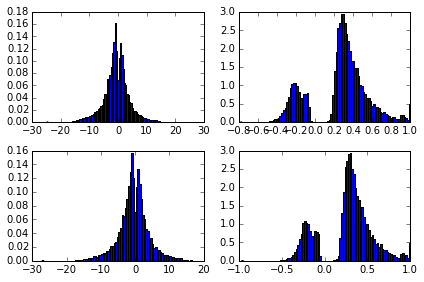

In [44]:
# plot distributions of delta and cor in rnd vs donor
# no significant difference
fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flat
hdata = mut_tf_prom[mut_tf_prom['delta'] != 0]
ax0.hist(hdata['delta'][hdata['rnd']], bins=100, normed=True)
ax2.hist(hdata['delta'][hdata['rnd']==False].reset_index(drop=True), bins=100, normed=True)
ax1.hist(mut_tf_prom['cor'][mut_tf_prom['rnd']].reset_index(drop=True), bins=100, normed=True)
ax3.hist(mut_tf_prom['cor'][mut_tf_prom['rnd']==False].reset_index(drop=True), bins=100, normed=True)
plt.tight_layout()
plt.show()

In [500]:
print len(set(mut_tf_prom['gene_name'][mut_tf_prom['delta'].abs()>5])), len(set(mut_tf_prom['gene_name']))

418 8838


In [174]:
# aggregate by donor, gene
x = mut_tf_prom[['gene_name', 'cancer', 'barcode', 'rnd', 'delta']]
x = x.groupby(['gene_name', 'cancer', 'barcode', 'rnd'])
x = x.aggregate([np.mean, np.sum, len, np.max, np.min, np.std])
x = x.unstack()
x['sumlen'] = x[('delta','len',False)] + x[('delta','len',True)]
x['difflen'] = x[('delta','len',False)] - x[('delta','len',True)]
x['fracdonor'] = x[('delta','len',False)] / x['sumlen']
x['diffmean'] = x[('delta','mean',False)] + x[('delta','mean',True)]
x['diffsum'] = x[('delta','sum',False)] - x[('delta','sum',True)]
x = x[(x['sumlen'] > 2) & (x['diffmean'] != 0)]
x = x.reset_index()
mut_tf_prom_barcode = x
x[:10]

gene_name cancer           barcode     delta                      \
                                            mean                 sum   
rnd                                        False      True     False   
0        A1CF    CRC  TCGA-A6-6141-01A  0.000000  0.900372  0.000000   
1        A1CF    CRC  TCGA-AA-3518-01A  0.000000 -6.336861  0.000000   
2        A1CF    CRC  TCGA-AD-6964-01A  0.000000 -1.153518  0.000000   
3        A1CF    CRC  TCGA-CA-6718-01A  0.000000  0.012168  0.000000   
4        A1CF    CRC  TCGA-EI-6917-01A  0.685280  0.000000  3.426400   
5        A1CF   LUAD  TCGA-05-4397-01A -1.458422 -1.924454 -4.375266   
6        A1CF   LUSC  TCGA-66-2759-01A -1.333859  0.000000 -4.001577   
7        A1CF   SKCM  TCGA-DA-A1HV-06A  0.665785  0.228992  2.663139   
8        A1CF   SKCM  TCGA-EE-A2M5-06A -0.321002  0.000000 -4.815027   
9        A1CF   SKCM  TCGA-EE-A3J5-06A -1.903344  0.000000 -7.613377   

                                                                            \
                len           amax                amin                 std   
rnd      True False True     False      True     False      True     False   
0    2.701115     4    3  0.000000  2.701115  0.000000  0.000000  0.000000   
1   -6.336861     2    1  0.000000 -6.336861  0.000000 -6.336861  0.000000   
2   -4.614073     2    4  0.000000  0.000000  0.000000 -4.614073  0.000000   
3    0.109514     7    9  0.000000  0.109514  0.000000  0.000000  0.000000   
4    0.000000     5    7  3.426400  0.000000  0.000000  0.000000  1.532333   
5   -3.848907     3    2  0.000000  0.000000 -4.375266 -3.848907  2.526061   
6    0.000000     3    1  0.000000  0.000000 -4.001577  0.000000  2.310312   
7    1.373954     4    6  2.663139  1.373954  0.000000  0.000000  1.331570   
8    0.000000    15   10  0.000000  0.000000 -4.815027  0.000000  1.243235   
9    0.000000     4    4  0.000000  0.000000 -7.613377  0.000000  3.806688   

              sumlen difflen fracdonor  diffmean   diffsum  
                                                            
rnd      True                                               
0    1.559490      7       1  0.571429  0.900372 -2.701115  
1         NaN      3       1  0.666667 -6.336861  6.336861  
2    2.307037      6      -2  0.333333 -1.153518  4.614073  
3    0.036505     16      -2  0.437500  0.012168 -0.109514  
4    0.000000     12      -2  0.416667  0.685280  3.426400  
5    2.721589      5       1  0.600000 -3.382876 -0.526359  
6         NaN      4       2  0.750000 -1.333859 -4.001577  
7    0.560914     10      -2  0.400000  0.894777  1.289186  
8    0.000000     25       5  0.600000 -0.321002 -4.815027  
9    0.000000      8       0  0.500000 -1.903344 -7.613377

In [176]:
# take those with largest changes in total TF binding, then those that occur in the most samples
x = mut_tf_prom_barcode
x = x[x['diffsum'].abs().rank(pct=True)>0.95]
x = x[['gene_name','barcode']].groupby('gene_name').aggregate({'barcode':len})
x = x.reset_index()
x = x[x['barcode'].rank(pct=True)>0.95]
x['gene_name'].to_csv('mut_tf_prom_barcode.txt',index=False)
# [Sheffield] enriched in GO terms for cell differentiation/development, and also synapse/neuron development (WTF??)
# [He] enriched in GO cell fate commitment, epithelium develo8pment, organ development (meh?)
# [Ernst, Thurman] similar - interesting terms on regulation, differentiation, development

In [177]:
# same thing but grouped by cancer type to look for significance within each tissue
x = mut_tf_prom_barcode.copy()
x['ranksum'] = x.groupby('cancer')['diffsum'].transform(lambda g: g.abs().rank(pct=True))
x = x[['gene_name','barcode','cancer']][x['ranksum']>0.98] # top 2% within each cancer type
x = x.groupby(['cancer', 'gene_name']).aggregate({'barcode':len}).reset_index()
x['ranklen'] = x.groupby('cancer')['barcode'].transform(lambda g: g.rank(pct=True))
x = x[x['ranklen'] > 0.95]
x.sort(['cancer', 'ranklen']).to_csv('mut_tf_prom_cancer.txt',index=False)
# [Sheffield] only significant in CRC, with same odd neuronal genes
# [He] significant in a couple of cancers, nothing pops out as a clear signal
# [Ernst, Thurman] nothing significant

In [45]:
x = x.groupby('gene_name')
x = x.aggregate({'difflen': [np.min, np.mean, np.max, len],
                 'diffmean': [np.min, np.mean, np.std, np.max],
                 'diffsum': [np.min, np.mean, np.std, np.max]})
x = x.fillna(0)
x = x[x[('difflen','len')] > 1]
x.describe()

diffsum                                                 difflen  \
               amin          mean           std          amax          amin   
count  15243.000000  15243.000000  15243.000000  15243.000000  15243.000000   
mean      -7.279257      0.168694      4.850079      7.871376     -4.541691   
std        6.272349      2.384941      2.362948      6.686689      5.349191   
min      -77.483018    -16.170108      0.000000    -15.356427   -201.000000   
25%      -10.601442     -1.094834      3.213971      3.185360     -6.000000   
50%       -6.319054      0.156672      4.765293      6.860283     -3.000000   
75%       -2.883609      1.422407      6.232450     11.456542     -2.000000   
max       11.687521     13.515573     23.724040    117.760952      4.000000   

                                                     diffmean                \
               mean          amax           len          amin          mean   
count  15243.000000  15243.000000  15243.000000  15243.000000  15243.000000   
mean      -0.470098      2.897133     12.168996     -3.196561     -0.357234   
std        1.054489      2.710048     18.144268      2.800718      1.114441   
min       -6.355224     -4.000000      2.000000    -21.290960    -14.220964   
25%       -1.094789      1.000000      3.000000     -4.384562     -0.763193   
50%       -0.500000      2.000000      6.000000     -2.546310     -0.266589   
75%        0.166667      4.000000     14.000000     -1.280841      0.146734   
max        9.666667     42.000000    335.000000      5.595922      9.262896   

                                   
                std          amax  
count  15243.000000  15243.000000  
mean       1.788915      2.236693  
std        1.231781      2.411223  
min        0.000000     -9.508995  
25%        1.023234      0.655698  
50%        1.510903      1.683317  
75%        2.212615      3.257443  
max       14.112262     18.188213

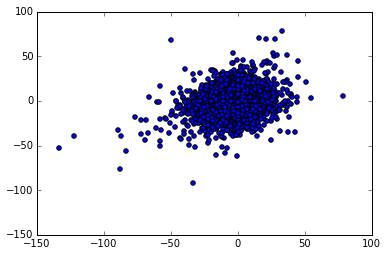

In [53]:
plt.scatter(x2[('delta','sum',True)], x2[('delta','sum',False)])
plt.show()

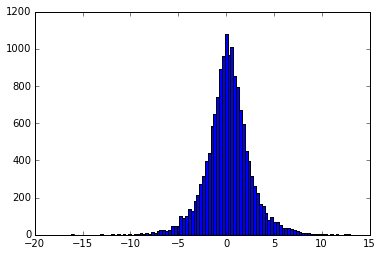

In [55]:
# GO shows no interesting terms for large diffsum
mut_tf_byprom = x
mut_tf_byprom[mut_tf_byprom[('diffsum','mean')].abs() > 10].to_csv('mut_tf_byprom.txt')
# plot is just normal
plt.hist(mut_tf_byprom[('diffsum','mean')][mut_tf_byprom[('diffsum','mean')]!=0],100)
plt.show()

In [166]:
mut_tf_prom = mut_tf_prom.merge(cmap, how='left')